In [9]:
%load_ext autoreload
%autoreload 3


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Set
import abc


history [7181, 2099, 3638, 6220, 3691, 1421, 9117, 5978, 8657, 5116, 4944, 7563, 9140, 7507, 94, 9155, 1842, 8366, 9320, 6723, 5389, 6582, 555, 9306, 4988, 3334, 6734, 4386, 9687, 9474, 4633, 5049, 3025, 1285, 8850, 7950, 421, 2473, 3093, 8495, 7259, 2751, 3194, 7677, 936, 2807, 8805, 8000, 6486, 6765, 5457, 7546, 7740, 8803, 6127, 6097, 8228, 3333, 9697, 9229, 695, 8152, 9892, 6563, 3737, 7645, 4573, 9285, 2601, 140, 4210, 2770, 2917, 1206, 9756, 7869, 6713, 1929, 3584, 6106, 4712, 8653, 3220, 4280, 661, 6478, 887, 5048, 3260, 5717, 8150, 9353, 3354, 9863, 8083, 6969, 7692, 6044, 2375, 5069, 1410, 4545, 3541, 6908, 7323, 8654, 4535, 1352, 9369, 6431, 8703, 8322, 1684, 585, 7741, 776, 2632, 933, 54, 334, 3770, 4336, 4857, 7185, 8644, 4758, 2257, 4250, 8050, 1343, 4105, 9302, 7393, 9883, 5589, 8290, 2762, 9825, 760, 6419, 9327, 1853, 2026, 9989, 5923, 5506, 3380, 2621, 1229, 3317, 2629, 8982, 9603, 2850, 4357, 9934, 5000, 2639, 8667, 1837, 1297, 1793, 1991, 4953, 2835, 173, 8628, 6128, 

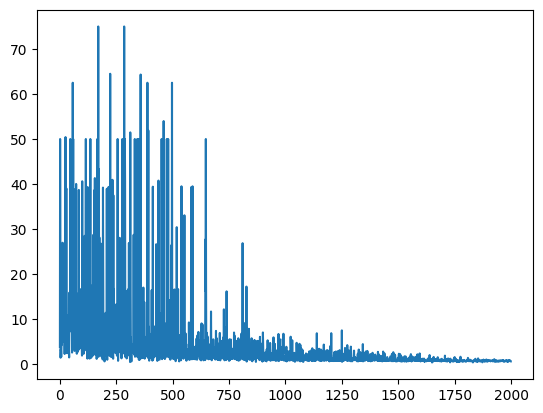

In [3]:
from markov_generator import RandomMarkovGenerator
from ffm import train_ffm, FieldAwareFactorizationMachine

# Those are somewhat good parameters
n = 10000  # Number of distinct pages
h = 10  # History length
m = h+2    # Number of fields (example value, h + 2)
k = 5   # Size of the latent factors


ffm = FieldAwareFactorizationMachine(n, m, k)
history = RandomMarkovGenerator(n).generate_sequence(1000)

cache = set(np.random.randint(0, n, size=20))
context = history[:h]

print("history", history)
print("cache", cache)
print("context", context)

losses= train_ffm(ffm, history, cache, h, epochs=2000, lr=0.01, wd=0.1, epoch_samples=4)

a, b = np.random.choice(list(cache), 2, replace=False)

print(f"p({a}, {b}) = ", ffm([a, b]+ context))
print(f"p({b}, {a}) = ", ffm([b, a]+ context))

plt.plot(losses)


In [37]:
from cache import Cache
from eviction import LRU, DOM
from prefetch import Next, Markov
from prob_model import FFM


# Tests on Markov generated traces

In [28]:
SEQ_LEN = 10000
N = 1000  # Address space size
SEQ_COUNT = 3  # Number of sequences to generate
CACHE_SIZE = 8

sequences = [
    RandomMarkovGenerator(N).generate_sequence(SEQ_LEN)
    for _ in range(SEQ_COUNT)
]


In [25]:
import time


def test_cache(cache: Cache, requests: List[int]) -> int:
    """Returns cache miss count for given cache and requests."""
    time_start = time.time()

    misses = 0
    for r in requests:
        if not cache.read(r):
            misses += 1

    time_end = time.time()

    print(f"Time taken: {time_end - time_start:.2f}s")
    print(f"Misses: {misses}")
    print(f"Hit rate: {1 - misses / len(requests):.3f}")

    return misses


In [39]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU",
        eviction_strategy=LRU(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.06s
Misses: 9910
Hit rate: 0.009
Sequence 1
Time taken: 0.05s
Misses: 9927
Hit rate: 0.007
Sequence 2
Time taken: 0.06s
Misses: 9931
Hit rate: 0.007


In [40]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU + NEXT",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.15s
Misses: 9910
Hit rate: 0.009
Sequence 1
Time taken: 0.13s
Misses: 9925
Hit rate: 0.007
Sequence 2
Time taken: 0.11s
Misses: 9926
Hit rate: 0.007


In [49]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU",
        eviction_strategy=LRU(),
        prefetch_strategy=Next(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.20s
Misses: 9910
Hit rate: 0.009
Sequence 1
Time taken: 0.21s
Misses: 9925
Hit rate: 0.007
Sequence 2
Time taken: 0.20s
Misses: 9926
Hit rate: 0.007


In [48]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "LRU + MARKOV(3)",
        eviction_strategy=LRU(),
        prefetch_strategy=Markov(2),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0
Time taken: 0.23s
Misses: 9910
Hit rate: 0.009
Sequence 1
Time taken: 0.23s
Misses: 9925
Hit rate: 0.007
Sequence 2
Time taken: 0.23s
Misses: 9926
Hit rate: 0.007


In [41]:
for i, seq in enumerate(sequences):
    print(f"Sequence {i}")

    cache = Cache(
        "DOM(FFM) + NEXT",
        eviction_strategy=DOM(prob_model=FFM(n=N)),
        prefetch_strategy=Next(),
        size=CACHE_SIZE,
    )
    test_cache(cache, seq)


Sequence 0


KeyboardInterrupt: 

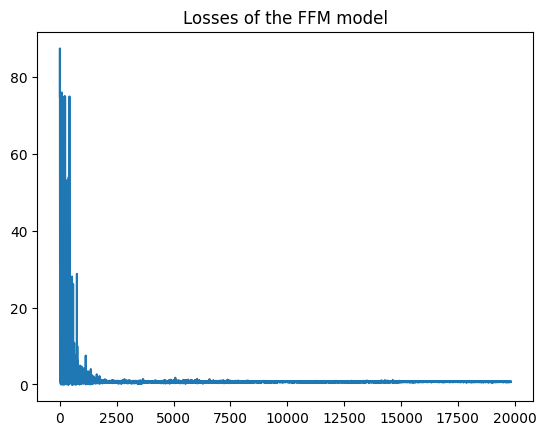

In [31]:
# To check if it's learning anything
plt.plot(cache.eviction_strategy.prob_model.losses)
plt.title("Losses of the FFM model")
plt.show()


In [2]:
from huawei_dataset import read_trace, get_test_set, get_reads, get_page_requests

test_set = get_test_set()

read_trace(test_set['1'][0][0])


,timestamp,tp,opCode,result,volumeId,objId,objLba,length,timepoint,last time nano,print data
NaN,Thu Nov 2 02:06:06 2017,PREFETCH,0x128001,0,0x59,0x59,173727232,16,1,18648389670988403,0
NaN,Thu Nov 2 02:06:06 2017,PREFETCH_DONE,0x128001,0,0x59,0x59,173727232,16,1,18648389671626787,c6d4d4e00000a206
NaN,Thu Nov 2 02:06:06 2017,READ_DONE,0x128001,0,0x59,0x59,173727232,16,1,18648389671637504,c6d4d4e00000a206
NaN,Thu Nov 2 02:06:06 2017,READ,0x128001,0,0x59,0x59,640764784,16,1,18648389674379950,0
NaN,Thu Nov 2 02:06:06 2017,PREFETCH,0x128001,0,0x59,0x59,640764784,16,1,18648389674396012,0
...,...,...,...,...,...,...,...,...,...,...,...
NaN,Thu Nov 2 02:07:59 2017,READ_DONE,0x128001,0,0x59,0x59,178450160,16,1,18648502893706999,c6a2f7ef0000a206
NaN,Thu Nov 2 02:07:59 2017,READ,0x128001,0,0x59,0x59,406216112,16,1,18648502958439917,0
NaN,Thu Nov 2 02:07:59 2017,PREFETCH,0x128001,0,0x59,0x59,406216112,16,1,18648502958455111,0
NaN,Thu Nov 2 02:07:59 2017,PREFETCH_DONE,0x128001,0,0x59,0x59,406216112,16,1,18648502959057908,ba858bdb0000a206


In [52]:
total_misses = 0
total_length = 0
unique = 0

unique_addresses = set()

for volume_paths in sorted(test_set['1']):
    cache = Cache(
        "DOM(FFM)",
        eviction_strategy=DOM(prob_model=FFM(n=300, k=100, h=6)),
        prefetch_strategy=None,
        p=1,
        size=8
    )
    print(volume_paths)
    for path in volume_paths:
        print(path)
        hits = 0

        requests = get_page_requests(get_reads(read_trace(path)))

        for r in requests:
            unique_addresses.add(r)
            hit = cache.read(r)
            hits += hit

        total_misses += len(requests) - hits
        total_length += len(requests)

print(f'Total misses: {total_misses}')
print(f'Total length: {total_length}')
print(f'Miss rate: {total_misses / total_length}')
print(f'Unique addresses: {len(unique_addresses)}')


['../trace/Trace/1/cache_trace_116/cache_trace_116_0_2', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_3', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_4', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_5', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_6', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_7', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_8', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_9', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_10', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_11', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_12', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_13', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_14', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_15', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_16', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_17', '../trace/Trace/1/cache_trace_116/cache_trace_116_0_18', '../trace/Trace/1/cache_trace_116/cach

In [12]:
from opt import opt_cache_simulation

total_misses = 0
total_length = 0

for volume_paths in sorted(test_set['1']):

    for path in volume_paths:
        requests = get_page_requests(get_reads(read_trace(path)))
        total_length += len(requests)

        misses = opt_cache_simulation(volume_paths, 8)
        total_misses += misses

print('---- Optimal offline cache ----')
print(f'Total misses: {total_misses}')
print(f'Total length: {total_length}')
